In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Installing Technical Analysis library
!pip install ta

  Preparing metadata (setup.py) ... - \ done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=4d4a6577f5fc82e9fa18b53f5b61245412daa54edfc340bcc835f7179fa42eba
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [3]:
# Installing yfinance library
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.3 MB/s eta 0:00:00


In [4]:
# Installing Quantstats
!pip install quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.2 MB/s eta 0:00:00


# ***Import dependencies***

In [5]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Machine Learning Metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

# Models
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# Feature Importance
from sklearn.inspection import permutation_importance

# Hyperparameter Tuning
import optuna

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ***Data Preprocessing***

In [6]:
# Loading Berkshire Hathaway data up until May 13th, 2023
brk = yf.download('BRK-B', end = '2023-05-13')
brk

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-05-09,22.200001,24.400000,22.200001,23.200001,23.200001,4290000
1996-05-10,24.000000,24.200001,23.600000,24.000000,24.000000,1060000
1996-05-13,24.000000,24.100000,23.299999,23.900000,23.900000,700000
1996-05-14,24.000000,24.100000,23.100000,23.600000,23.600000,310000
1996-05-15,23.600000,23.700001,23.000000,23.200001,23.200001,545000
...,...,...,...,...,...,...
2023-05-08,328.260010,330.690002,325.790009,326.140015,326.140015,3302400
2023-05-09,324.869995,326.880005,323.480011,324.869995,324.869995,2283400
2023-05-10,326.079987,326.160004,320.149994,322.989990,322.989990,2639800


In [7]:
# Creating a Candlestick chart for Berkshire Hathaway stocks
candlestick = go.Candlestick(x=brk.index,
                open=brk['Open'],
                high=brk['High'],
                low=brk['Low'],
                close=brk['Adj Close'],
                increasing=dict(line=dict(color='black')),
                decreasing=dict(line=dict(color='red')),
                showlegend=False)

# Layout
layout = go.Layout(
    title='Adjusted Berkshire Hathaway Class B Shares Price - 1996 to 2023',
    yaxis=dict(title='Price (USD)'),
    xaxis=dict(title='Date'),
    template = 'ggplot2',
    xaxis_rangeslider_visible=False,
    yaxis_gridcolor='white',
    xaxis_gridcolor='white',
    yaxis_tickfont=dict(color='black'),
    xaxis_tickfont=dict(color='black'),
    margin=dict(t=50,l=50,r=50,b=50)
)

fig = go.Figure(data=[candlestick], layout=layout)

# Plotting annotation
fig.add_annotation(text='Berkshire Hathaway Class B (BRK-B)',
                    font=dict(color='gray', size=30),
                    xref='paper', yref='paper',
                    x=0.5, y=0.5,
                    showarrow=False,
                    opacity=.85)

fig.show()

In [8]:
# Data Splitting
train = brk[brk.index.year <= 2016]
test = brk[brk.index.year >= 2017]

In [9]:
# Visualizing the training set from 1996 to 2016
train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-05-09,22.200001,24.400000,22.200001,23.200001,23.200001,4290000
1996-05-10,24.000000,24.200001,23.600000,24.000000,24.000000,1060000
1996-05-13,24.000000,24.100000,23.299999,23.900000,23.900000,700000
1996-05-14,24.000000,24.100000,23.100000,23.600000,23.600000,310000
1996-05-15,23.600000,23.700001,23.000000,23.200001,23.200001,545000
...,...,...,...,...,...,...
2016-12-23,166.259995,166.440002,164.770004,165.320007,165.320007,2043100
2016-12-27,165.509995,165.820007,164.779999,164.949997,164.949997,2133800
2016-12-28,165.449997,165.639999,163.559998,163.750000,163.750000,2626800


# ***Feature Engineering***

In [10]:
# Defining feature creation function
def feature_engineering(df):
    
    # Price behavior features
    df['high_low_ratio'] = df['High'] / df['Low']
    df['open_adjclose_ratio'] = df['Open'] / df['Adj Close']
    df['candle_to_wick_ratio'] = (df['Adj Close'] - df['Open']) / (df['High'] - df['Low'])
    df['candle_to_wick_ratio'] = df['candle_to_wick_ratio'].replace([np.inf, -np.inf], 0)
    
    # Lagged values
    df['Close_lag1'] = df['Adj Close'].shift(1)
    df['Close_lag2'] = df['Adj Close'].shift(2)
    df['Close_lag3'] = df['Adj Close'].shift(3)
    df['Close_lag5'] = df['Adj Close'].shift(5)
    
    # Close to lags ratio
    df['Close_lag1_ratio'] = df['Adj Close'] / df['Close_lag1']
    df['Close_lag2_ratio'] = df['Adj Close'] / df['Close_lag2']
    df['Close_lag3_ratio'] = df['Adj Close'] / df['Close_lag3'] 
    df['Close_lag5_ratio'] = df['Adj Close'] / df['Close_lag5'] 
    
    # Simple moving averages
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'], window = 10)
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'], window = 20)
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'], window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'], window = 100)
    
    # Close to averages ratio
    df['Close_sma10_ratio'] = df['Adj Close'] / df['sma10']
    df['Close_sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['Close_sma80_ratio'] = df['Adj Close'] / df['sma80']
    df['Close_sma100_ratio'] = df['Adj Close'] / df['sma100']
    
    
    # Shorter SMA to longer SMA ratio
    df['sma10_sma20_ratio'] = df['sma10'] / df['sma20']
    df['sma20_sma80_ratio'] = df['sma20'] / df['sma80']
    df['sma80_sma100_ratio'] = df['sma80'] / df['sma100']
    df['sma10_sma80_ratio'] = df['sma10'] / df['sma80']
    df['sma20_sma100_ratio'] = df['sma20'] / df['sma100']
    
    # Classical technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20, constant=0.015)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(20).sum()
    
    # Daily returns in %
    df['returns_in_%'] = np.round((df['Adj Close'].pct_change()) * 100, 2)
    
    # Target variable – Daily returns shifted to a day earlier
    df['target'] = df['returns_in_%'].shift(-1)
    
    # Remove null values
    df.dropna(inplace = True)
    return df  # Return data frame with the new features above

In [11]:
# Applying the function above to the train and test sets
train = feature_engineering(train)
test = feature_engineering(test)

In [12]:
train # Visualizing results

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1,...,sma20_sma100_ratio,rsi,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_10_days,obv_divergence_20_days,returns_in_%,target
Date,,,,,,,,,,,,,,,,,,,,,
1996-09-30,21.280001,21.600000,21.280001,21.459999,21.459999,55000,1.015038,0.991612,0.562496,21.360001,...,1.003602,52.451051,0,0,19.657101,3355000,-1.149996e+05,1.299994e+05,0.47,-1.03
1996-10-01,21.459999,21.459999,21.160000,21.240000,21.240000,70000,1.014178,1.010358,-0.733333,21.459999,...,1.005182,46.664615,0,0,-41.256578,3285000,-3.999958e+04,4.499972e+04,-1.03,0.85
1996-10-02,21.200001,21.440001,21.200001,21.420000,21.420000,75000,1.011321,0.989729,0.916665,21.240000,...,1.007388,51.389821,0,0,-27.149134,3360000,1.400001e+05,9.499958e+04,0.85,-0.09
1996-10-03,21.459999,21.459999,21.340000,21.400000,21.400000,40000,1.005623,1.002804,-0.500000,21.420000,...,1.009749,50.850740,0,0,-21.807010,3320000,3.500026e+04,9.999950e+04,-0.09,0.00
1996-10-04,21.360001,21.459999,21.320000,21.400000,21.400000,70000,1.006567,0.998131,0.285708,21.400000,...,1.011643,50.850740,0,0,-39.279503,3390000,6.500034e+04,1.399996e+05,0.00,-0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-22,165.770004,166.119995,164.889999,166.029999,166.029999,2511600,1.007459,0.998434,0.211378,165.949997,...,1.081211,69.999671,0,0,62.915292,600638600,1.351530e+07,1.919479e+07,0.05,-0.43
2016-12-23,166.259995,166.440002,164.770004,165.320007,165.320007,2043100,1.010135,1.005686,-0.562867,166.029999,...,1.082023,66.070528,0,0,54.960756,598595500,7.584300e+06,1.537449e+07,-0.43,-0.22
2016-12-27,165.509995,165.820007,164.779999,164.949997,164.949997,2133800,1.006311,1.003395,-0.538455,165.320007,...,1.083101,64.052697,0,0,43.652107,596461700,-1.309199e+06,1.744499e+07,-0.22,-0.73


In [13]:
X_train = train.drop('target', axis = 1) # Independent features X
y_train = train.target # target variable y

X_test = test.drop('target', axis = 1) # Independent features X
y_test = test.target # target variable y

# ***Feature Selection***

In [14]:
# Initiating SelectKBest using f_regression as score function
k_best = SelectKBest(score_func = f_regression, k = 38)

In [15]:
# Fitting and transforming 
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

In [16]:
# Obtaining indices and feature names
feature_indices = k_best.get_support(indices = True)
feature_names = X_train.columns[feature_indices]

In [17]:
# Obtaining p-values
p_values = k_best.pvalues_

In [18]:
# Creating features list
features = []

# Selecting only features with p-values below 0.2
for feature, pvalue in zip(feature_names, p_values):
    if pvalue < 0.2:
        features.append(feature)

# Printing features        
print("Selected Features:")
print(features)

Selected Features:
['high_low_ratio', 'open_adjclose_ratio', 'Close_lag1_ratio', 'Close_lag5_ratio', 'Close_sma10_ratio', 'Close_sma20_ratio', 'Close_sma80_ratio', 'Close_sma100_ratio', 'sma10_sma20_ratio', 'sma10_sma80_ratio', 'rsi', 'rsi_oversold', 'cci', 'returns_in_%']


In [19]:
# Creating new X datasets containing only the selected features
X_train_kbest = X_train[features]
X_test_kbest = X_test[features]

In [20]:
X_train_kbest # Visualizing results

,high_low_ratio,open_adjclose_ratio,Close_lag1_ratio,Close_lag5_ratio,Close_sma10_ratio,Close_sma20_ratio,Close_sma80_ratio,Close_sma100_ratio,sma10_sma20_ratio,sma10_sma80_ratio,rsi,rsi_oversold,cci,returns_in_%
Date,,,,,,,,,,,,,,
1996-09-30,1.015038,0.991612,1.004682,0.997212,0.995916,1.002804,1.015702,1.006416,1.006916,1.019867,52.451051,0,19.657101,0.47
1996-10-01,1.014178,1.010358,0.989748,0.985158,0.987631,0.991874,1.005503,0.997015,1.004296,1.018096,46.664615,0,-41.256578,-1.03
1996-10-02,1.011321,0.989729,1.008475,0.997207,0.996650,0.999300,1.013893,1.006683,1.002659,1.017301,51.389821,0,-27.149134,0.85
1996-10-03,1.005623,1.002804,0.999066,0.996276,0.996925,0.997204,1.012946,1.006926,1.000280,1.016070,50.850740,0,-21.807010,-0.09
1996-10-04,1.006567,0.998131,1.000000,1.001873,0.998507,0.996368,1.013306,1.007970,0.997858,1.014821,50.850740,0,-39.279503,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-22,1.007459,0.998434,1.000482,1.001810,1.002088,1.019537,1.096724,1.102334,1.017412,1.094438,69.999671,0,62.915292,0.05
2016-12-23,1.010135,1.005686,0.995724,1.003399,0.997526,1.012956,1.090698,1.096042,1.015468,1.093403,66.070528,0,54.960756,-0.43
2016-12-27,1.006311,1.003395,0.997762,0.997581,0.995997,1.008224,1.086948,1.092008,1.012277,1.091317,64.052697,0,43.652107,-0.22


# ***Modelling***

In [21]:
# Best Features
regressors = [
    LinearRegression(),
    Ridge(random_state = 42),
    ExtraTreesRegressor(random_state = 42),
    GradientBoostingRegressor(random_state = 42),
    KNeighborsRegressor(),
    XGBRegressor(random_state = 42),
    LGBMRegressor(random_state = 42),
    CatBoostRegressor(random_state = 42, verbose = False),
    AdaBoostRegressor(random_state = 42),
    RandomForestRegressor(random_state = 42)
]

# Iterating over algorithms and printing scores
for reg in regressors:
    reg.fit(X_train_kbest, y_train)
    y_pred = reg.predict(X_test_kbest)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(f'{type(reg).__name__}: R² = {r2:.2f}, Root Mean Squared Error = {rmse:.2f}')

LinearRegression: R² = -0.01, Root Mean Squared Error = 1.38
Ridge: R² = -0.01, Root Mean Squared Error = 1.38
ExtraTreesRegressor: R² = -0.05, Root Mean Squared Error = 1.41
GradientBoostingRegressor: R² = -0.01, Root Mean Squared Error = 1.39
KNeighborsRegressor: R² = -0.19, Root Mean Squared Error = 1.51
XGBRegressor: R² = -0.12, Root Mean Squared Error = 1.46
LGBMRegressor: R² = -0.11, Root Mean Squared Error = 1.46
CatBoostRegressor: R² = -0.06, Root Mean Squared Error = 1.42
AdaBoostRegressor: R² = -0.04, Root Mean Squared Error = 1.41
RandomForestRegressor: R² = -0.06, Root Mean Squared Error = 1.42


In [22]:
# All Features
regressors = [
    LinearRegression(),
    Ridge(random_state = 42),
    ExtraTreesRegressor(random_state = 42),
    GradientBoostingRegressor(random_state = 42),
    KNeighborsRegressor(),
    XGBRegressor(random_state = 42),
    LGBMRegressor(random_state = 42),
    CatBoostRegressor(random_state = 42, verbose = False),
    AdaBoostRegressor(random_state = 42),
    RandomForestRegressor(random_state = 42)
]

# Iterating over algorithms and printing scores
for reg in regressors:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(f'{type(reg).__name__}: R² = {r2:.2f}, Root Mean Squared Error = {rmse:.2f}')

LinearRegression: R² = -0.15, Root Mean Squared Error = 1.48
Ridge: R² = -0.20, Root Mean Squared Error = 1.51
ExtraTreesRegressor: R² = -0.10, Root Mean Squared Error = 1.45
GradientBoostingRegressor: R² = 0.01, Root Mean Squared Error = 1.37
KNeighborsRegressor: R² = -0.88, Root Mean Squared Error = 1.89
XGBRegressor: R² = -0.27, Root Mean Squared Error = 1.55
LGBMRegressor: R² = -0.14, Root Mean Squared Error = 1.47
CatBoostRegressor: R² = -0.08, Root Mean Squared Error = 1.43
AdaBoostRegressor: R² = -0.01, Root Mean Squared Error = 1.38
RandomForestRegressor: R² = -0.05, Root Mean Squared Error = 1.41


Gradient boost regressor is best in all these R² = -0.02, Root Mean Squared Error = 1.43

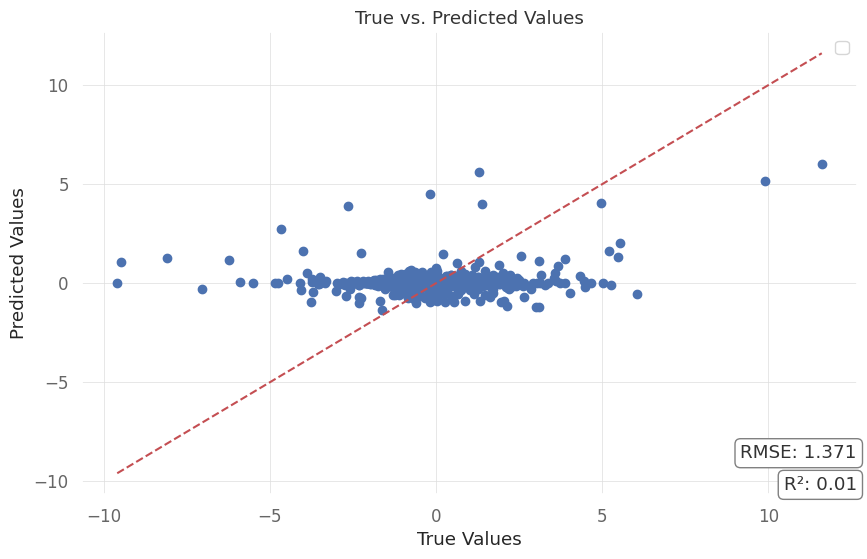

In [23]:
# Instantiating GradientBoostingRegressor model
model = GradientBoostingRegressor(random_state = 42)

# Fitting, testing, and computing scores
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)

# Plotting scatter plot – y_test x y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
box = dict(boxstyle="round, pad=0.3", fc="white", ec="gray", lw=1)
plt.text(plt.xlim()[1], plt.ylim()[0]+0.02, f"R²: {r2:.2f}", ha='right', va='bottom', wrap = True, bbox = box)
plt.text(plt.xlim()[1], plt.ylim()[0]*0.85 + 0.02, f"RMSE: {rmse:.3f}", ha='right', va='bottom', wrap = True, bbox = box) 

plt.legend()
plt.show()

In [24]:
# Daily returns plot y_pred x y_test
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_test, mode='lines', name='True Values'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_pred, mode='lines', name='Predicted Values'))
fig.update_layout(title='True vs. Predicted Values', xaxis_title='Index', yaxis_title='Values')
fig.show()

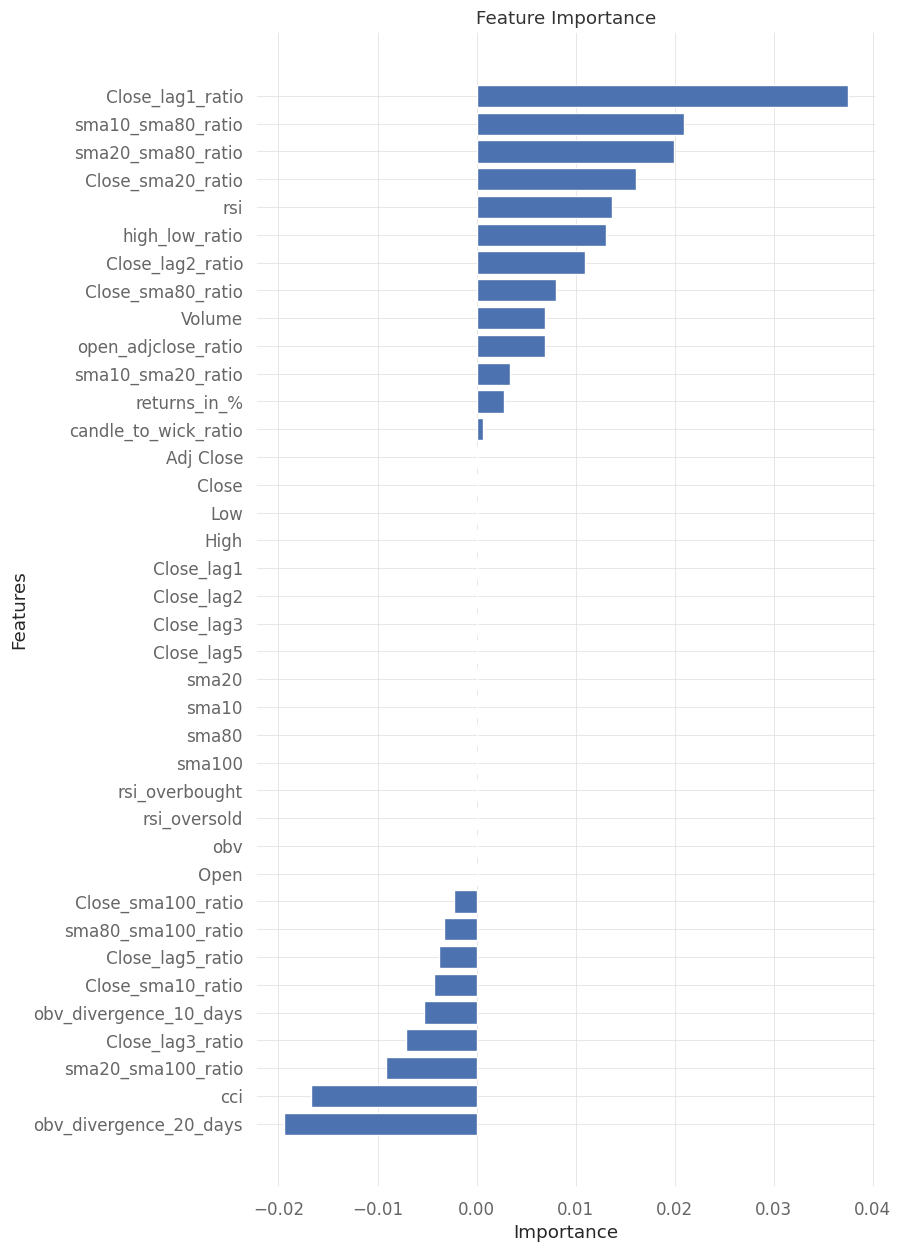

In [25]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) # Computing feature importance

# Computing mean scores and obtaining features' names
importances = result.importances_mean
feature_names = X_test.columns

# Sorting Features importances and names
indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Plotting Feature Importance plot
fig, ax = plt.subplots(figsize = (8,15))
ax.barh(sorted_features, sorted_importances)
ax.set_yticklabels(sorted_features)
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.show()

# Tunning Model

In [26]:
# Defining objective function
def objective(trial):
    
    # Defining different parameter settigns to iterate over
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': 42
    }

    # Fitting and predicting 
    tuning = GradientBoostingRegressor(**params)
    tuning.fit(X_train, y_train)
    preds = tuning.predict(X_test)

    # Computing RMSE score
    rmse = np.round(mean_squared_error(y_test, preds, squared = False), 3)
    return rmse # Returining the score

In [27]:
study = optuna.create_study(direction = 'minimize') # Creating study
study.optimize(objective, n_trials = 100, show_progress_bar = True) # Running study

[I 2023-05-24 04:46:05,118] A new study created in memory with name: no-name-7b50d5fc-a57c-434c-b9c3-63e5d366613c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-24 04:47:00,762] Trial 0 finished with value: 2.214 and parameters: {'loss': 'quantile', 'n_estimators': 650, 'learning_rate': 0.04830413840915473, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 2, 'subsample': 0.4758173026828506}. Best is trial 0 with value: 2.214.
[I 2023-05-24 04:47:36,173] Trial 1 finished with value: 1.398 and parameters: {'loss': 'huber', 'n_estimators': 550, 'learning_rate': 0.05466478913998786, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 7, 'subsample': 0.9149502642898009}. Best is trial 1 with value: 1.398.
[I 2023-05-24 04:47:51,080] Trial 2 finished with value: 1.392 and parameters: {'loss': 'huber', 'n_estimators': 350, 'learning_rate': 0.017942596805940975, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 12, 'subsample': 0.35890646445416974}. Best is trial 2 with value: 1.392.
[I 2023-05-24 04:48:26,707] Trial 3 finished with value: 2.249 and parameters: {'loss': 'quantile', 'n_estimators': 850, 'learn

In [28]:
print('Best parameters:', study.best_params) # Printing the best parameters setting
print('Best score:', study.best_value) # Printing the lowest RMSE score found

Best parameters: {'loss': 'squared_error', 'n_estimators': 150, 'learning_rate': 0.03019229982284584, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.23784698935183318}
Best score: 1.364


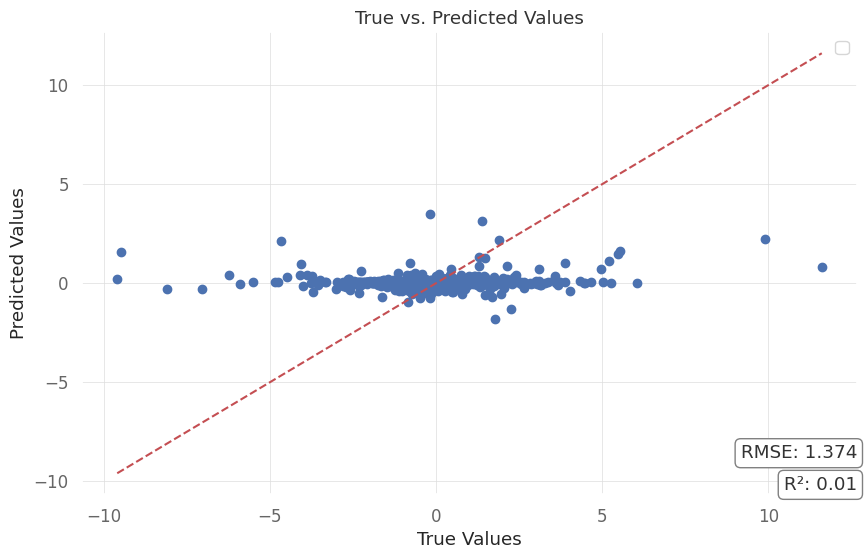

In [29]:
# Instantiating model with the best parameters settings 
model = GradientBoostingRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)

# Plotting scatter plot – y_test x y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
box = dict(boxstyle="round, pad=0.3", fc="white", ec="gray", lw=1)
plt.text(plt.xlim()[1], plt.ylim()[0]+0.02, f"R²: {r2:.2f}", ha='right', va='bottom', wrap = True, bbox = box)
plt.text(plt.xlim()[1], plt.ylim()[0]*0.85 + 0.02, f"RMSE: {rmse:.3f}", ha='right', va='bottom', wrap = True, bbox = box) 

plt.legend()
plt.show()


In [30]:
# Daily returns plot y_pred x y_test
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_test, mode='lines', name='True Values'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_pred, mode='lines', name='Predicted Values'))
fig.update_layout(title='True vs. Predicted Values', xaxis_title='Index', yaxis_title='Values')
fig.show()


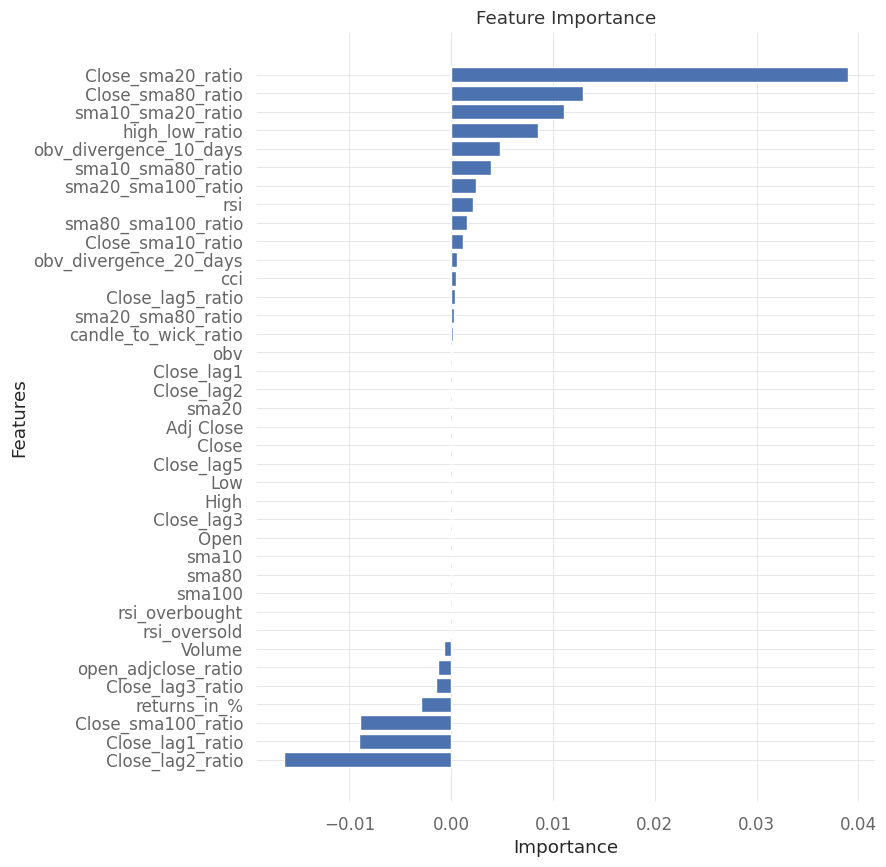

In [31]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) # Obtaining permutation importance

importances = result.importances_mean
feature_names = X_test.columns

indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

fig, ax = plt.subplots(figsize = (8,10))
ax.barh(sorted_features, sorted_importances)
ax.set_yticklabels(sorted_features)
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')
plt.show()

# Developing a trading strategy

In [32]:
y_pred # Displaying y_pred values

array([0.03989046, 0.03989046, 0.03989046, ..., 0.03989046, 0.03989046,
       0.03989046])

In [33]:
y_test # Displaying y_test values

Date
2017-05-25    0.24
2017-05-26   -0.35
2017-05-30    0.10
2017-05-31    0.83
2017-06-01   -0.22
              ... 
2023-05-05    0.70
2023-05-08   -0.39
2023-05-09   -0.58
2023-05-10   -0.11
2023-05-11   -0.05
Name: target, Length: 1501, dtype: float64

In [34]:
# Creating class array based on predicted returns
y_pred_class = np.where(y_pred > 0, 1, 0) 
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
# Creating class array based on actual returns
y_test_class = np.where(y_test > 0, 1, 0)
y_test_class

array([1, 0, 1, ..., 0, 0, 0])

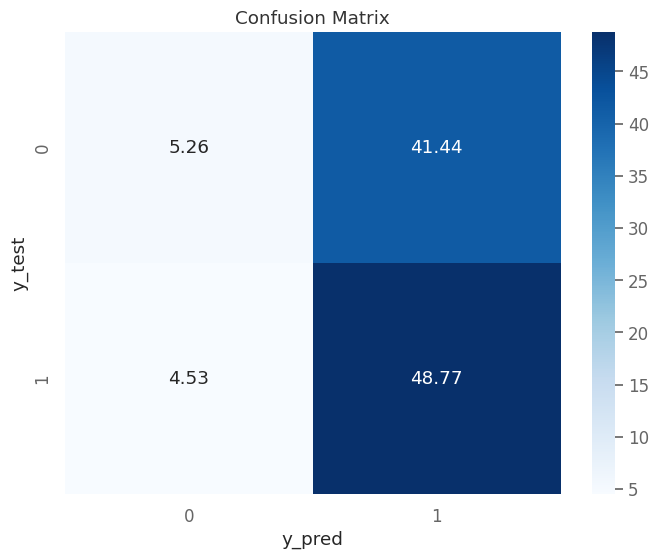

In [36]:
# Computing confusion matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Transforming values to %
conf_matrix = conf_matrix / np.sum(conf_matrix) * 100

# Plotting conf matrix
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues',
           fmt = '.2f')

plt.title('Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [37]:
X_test['sign'] = y_pred_class # Creating 'sign' variable, indicating the following day's direction 
X_test['current_position'] = X_test['sign'].shift(1) # Current position
X_test['model_returns'] = X_test['current_position'] * X_test['returns_in_%'] # Model returns

In [38]:
X_test # Displaying dataframe with new features added above

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1,...,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_10_days,obv_divergence_20_days,returns_in_%,sign,current_position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-25,165.229996,165.500000,164.710007,165.300003,165.300003,2605300,1.004796,0.999576,0.088618,164.929993,...,0,0,33.562087,4303000,1.484050e+07,1.157620e+07,0.22,1,NaN,NaN
2017-05-26,165.250000,165.880005,165.020004,165.690002,165.690002,2156300,1.005211,0.997344,0.511630,165.300003,...,0,0,51.977824,6459300,1.340450e+07,1.677750e+07,0.24,1,1.0,0.24
2017-05-30,165.789993,165.869995,164.470001,165.110001,165.110001,3048300,1.008512,1.004118,-0.485711,165.690002,...,0,0,34.434969,3411000,7.397199e+06,1.059380e+07,-0.35,1,1.0,-0.35
2017-05-31,165.270004,165.449997,164.100006,165.279999,165.279999,5674900,1.008227,0.999940,0.007403,165.110001,...,0,0,26.785716,9085900,1.550700e+07,1.348750e+07,0.10,1,1.0,0.10
2017-06-01,165.800003,166.690002,164.750000,166.660004,166.660004,3330900,1.011775,0.994840,0.443299,165.279999,...,0,0,88.538344,12416800,2.363529e+07,1.383620e+07,0.83,1,1.0,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05,323.359985,325.160004,322.619995,323.880005,323.880005,3869500,1.007873,0.998394,0.204731,320.000000,...,0,0,30.184916,215733900,-2.439955e+04,2.381189e+07,1.21,1,1.0,1.21
2023-05-08,328.260010,330.690002,325.790009,326.140015,326.140015,3302400,1.015040,1.006500,-0.432653,323.880005,...,0,0,96.355682,219036300,1.016100e+06,2.478339e+07,0.70,1,1.0,0.70
2023-05-09,324.869995,326.880005,323.480011,324.869995,324.869995,2283400,1.010511,1.000000,0.000000,326.140015,...,0,0,38.206154,216752900,1.284899e+06,1.939049e+07,-0.39,1,1.0,-0.39


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-05-25  2017-05-25
End Period                 2023-05-11  2023-05-11
Risk-Free Rate             0.0%        0.0%
Time in Market             90.0%       100.0%

Cumulative Return          180.37%     95.96%
CAGR﹪                     18.87%      11.94%

Sharpe                     0.97        0.63
Prob. Sharpe Ratio         99.12%      93.61%
Smart Sharpe               0.81        0.52
Sortino                    1.45        0.9
Smart Sortino              1.21        0.75
Sortino/√2                 1.03        0.63
Smart Sortino/√2           0.86        0.53
Omega                      1.21        1.21

Max Drawdown               -25.32%     -29.55%
Longest DD Days            419         428
Volatility (ann.)          19.89%      21.89%
R^2                        0.83        0.83
Information Ratio          0.04        0.04
Calmar                     0.75        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-03-29,2022-10-12,2023-05-11,408,-25.323981,-24.386372
2,2020-01-21,2020-03-12,2020-05-08,108,-19.035164,-18.840903
3,2018-11-09,2018-12-24,2020-01-02,419,-14.829999,-13.267824
4,2018-03-12,2018-06-27,2018-08-06,147,-10.723667,-9.985549
5,2020-09-03,2020-10-28,2020-11-13,71,-9.542240,-9.370370


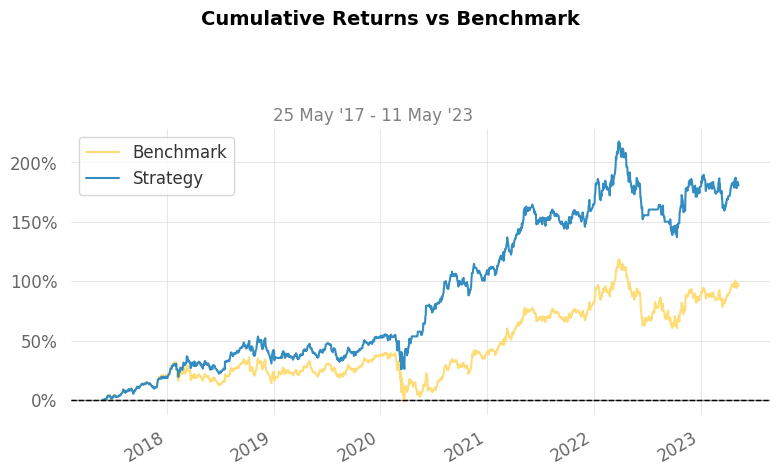

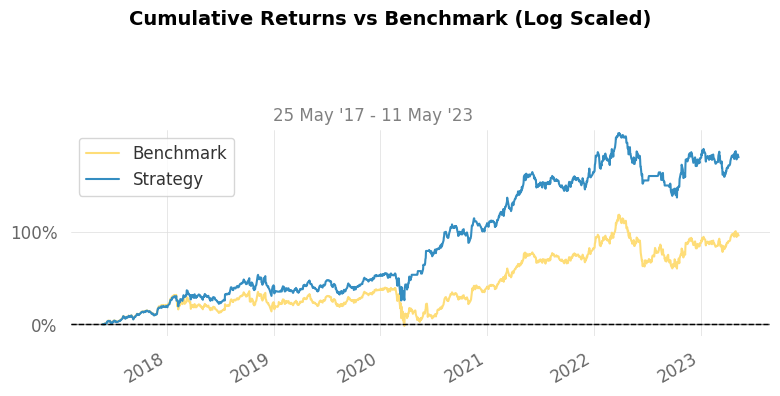

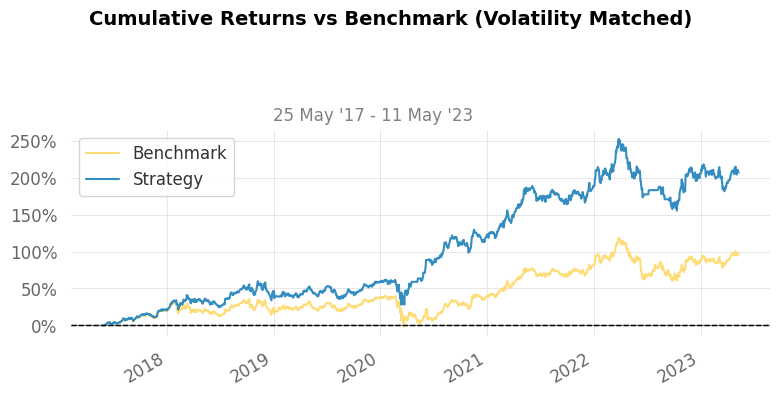

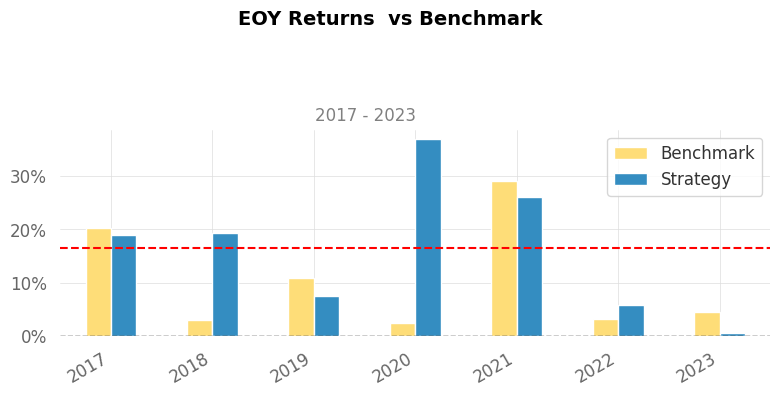

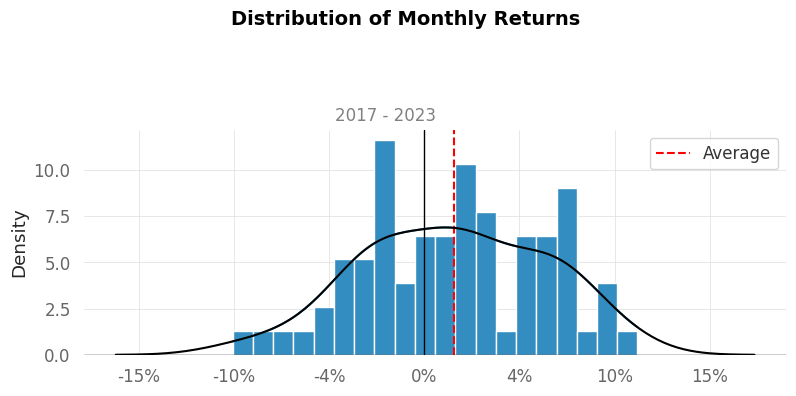

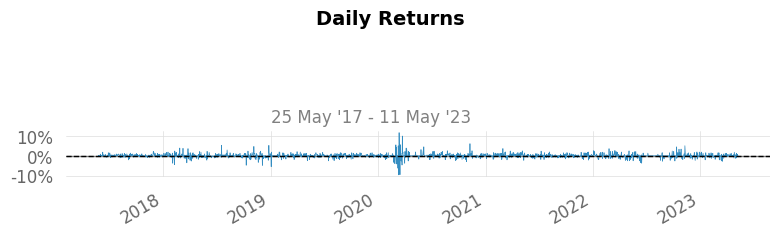

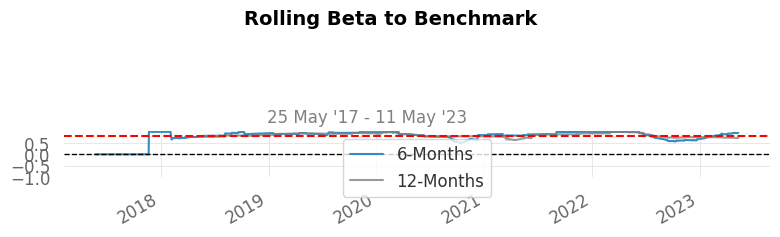

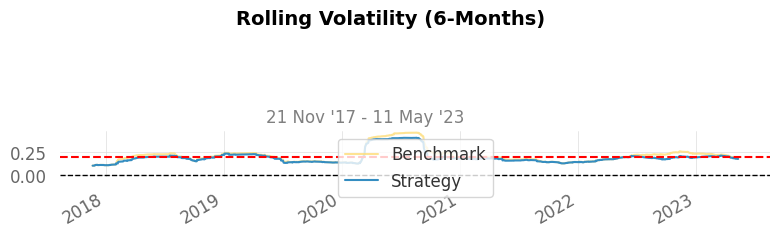

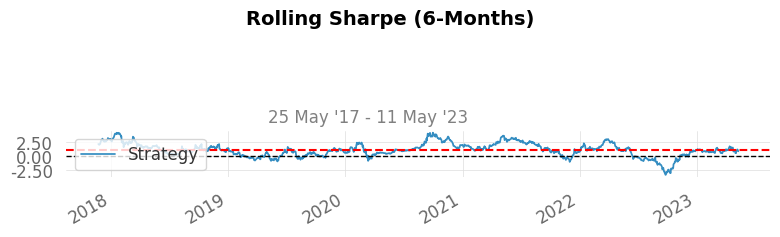

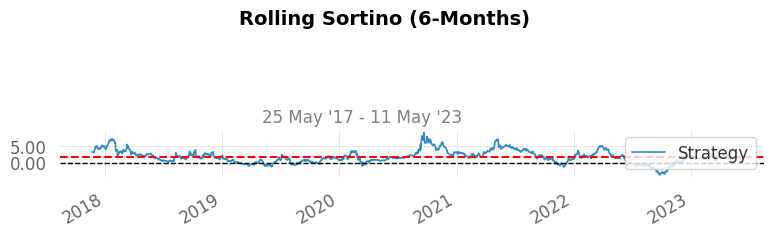

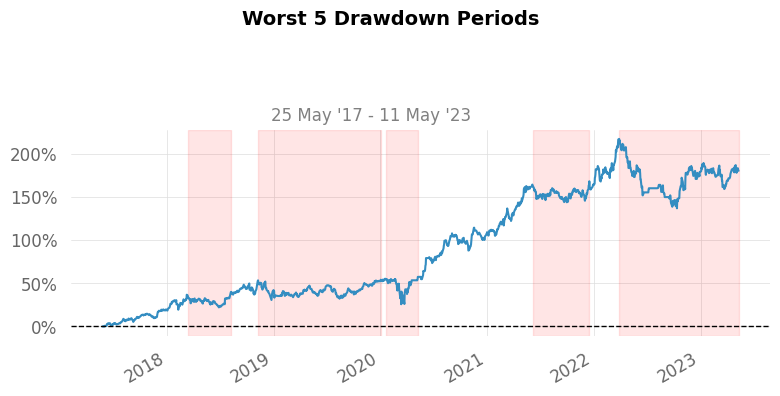

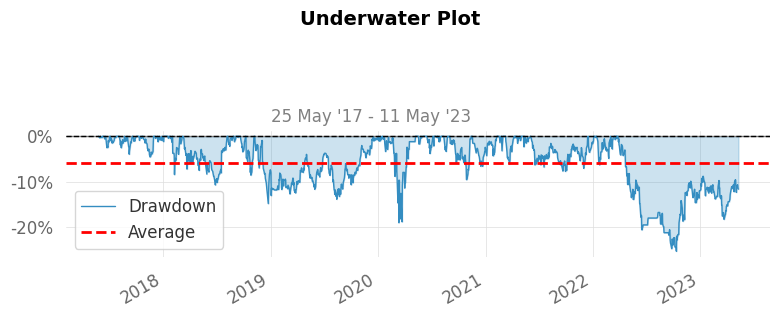

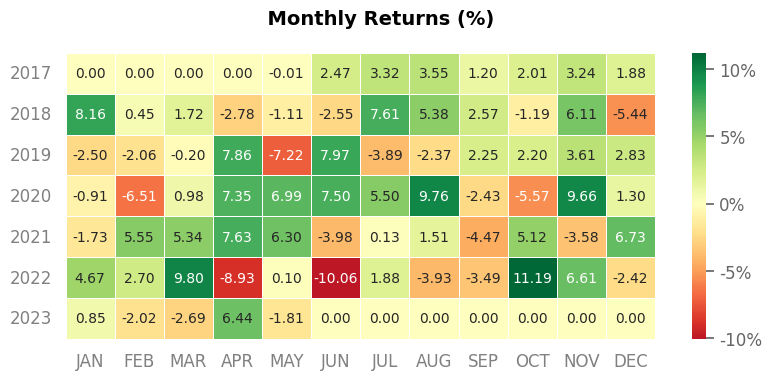

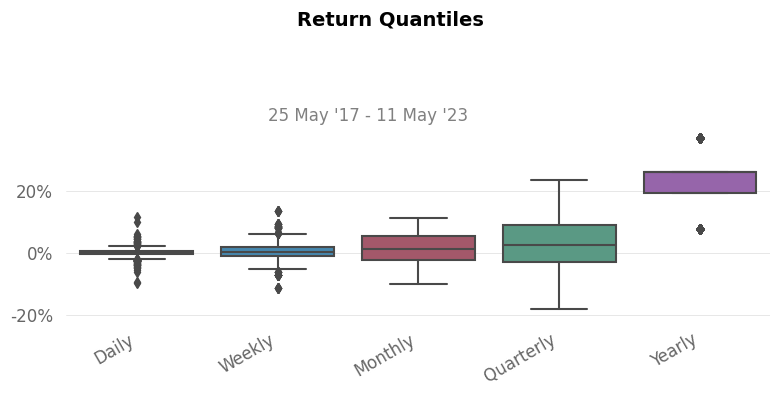

In [39]:
# Converting % values to decimal values
model_returns = X_test['model_returns'] / 100
buy_and_hold = X_test['returns_in_%'] / 100

# Generating full report on the model strategy and comparing it to a Buy & Hold approach
qs.reports.full(model_returns, benchmark = buy_and_hold)

# Conclusion

We have successfully built a regression model that outperforms a Buy & Hold strategy in both cumulative return and risk factor.

Of course, this is not an investment advice in any way or form. The model we have built above may not be suitable for every asset, market, or even personal “taste”, and there are many improvements that could be made to achieve higher performances in a trading environment.

You can try using ensemble methods by creating a metamodel from the models we have experienced with, to try to achieve better R² and RMSE scores. I have also seen other traders defining a threshold different from 0 when creating arrays that are similar to those we have created when assigning binary values to y_pred_class and y_test_class, when building similar models and strategies.

Overall, I highly suggest you take these notebooks as just an initial guide on how to use machine learning to leverage your investing and trading skills. I strongly recommend you make different experiments, and don't forget to leave comments with your suggestions and insights for improving these models and strategies. I will definitely take your insights into consideration on the next notebooks of this series.